In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchvision import transforms, datasets

In [ ]:
batch_size = 150
epochs = 30
l_rate = 3e-4
patch_size = 4
num_classes = 10
image_size = 32
CHANNELS = 3
EMBED_DIM = 256 # dimension of each patch
NUM_HEADS = 8 # no. of attention heads
DEPTH = 9 # No. of transform blocks
MLP_DIM = 512
DROP_RATE = 0.1 # 10% chance of dropping a unit from a neuron

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Do augmentation first
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 specific normalization
]) # adjustes the values by +- 20%

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


In [ ]:
#train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)

validation = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_test)

train_size = int(0.8 * len(train))
val_size = len(train) - train_size

train_subset, _ = random_split(train, [train_size, val_size])
_, val_subset = random_split(validation, [train_size, val_size])

test_dataset = datasets.CIFAR10(root="./data",
                                train=False,
                                download=True,
                                transform=transform_test)



100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [ ]:
train_loader = DataLoader(dataset=train_subset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_subset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

In [ ]:
class Patch_embd(nn.Module):
  def  __init__(self,image_size,patch_size,CHANNELS,EMBED_DIM):
    super().__init__()
    self.patch = patch_size
    self.conv = nn.Conv2d(in_channels=CHANNELS,out_channels=EMBED_DIM,kernel_size=patch_size,stride=patch_size)
    num_patch = (image_size//patch_size)**2
    self.CLS=nn.Parameter(torch.randn(1,1,EMBED_DIM))# creates tokens for each image in a batch
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patch,EMBED_DIM))
  def forward(self,x):
     B = x.size(0)
     x = self.conv(x) # (B, E, H/P, W/P)
     x = x.flatten(2).transpose(1, 2) # (B, N, E) transpose bcoz it expects input int this format
     cls_tokens = self.CLS.expand(B, -1, -1) # creates a batch of tokens for each image  of size of embedded dim
     x = torch.cat((cls_tokens, x), dim=1) # adds one more patch/token for cls i.e 64+1=65
     x = x + self.pos_embed
     return x


class MLP(nn.Module):
  def __init__(self,in_features,hidden_features,drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)# converts embedded dim to mlp dim  and adds weights and biases
    self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)

  def forward(self, x):
    x = self.dropout(F.gelu(self.fc1(x)))#gelu function non linearize data
    x = self.dropout(self.fc2(x))# dropout to avoid overfitting and to stop relying on few neurons for output
    return x


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)# adds normalization layer to reduce the value It improves training stability and gradient flow.
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True) # mutihead attentions identifies patterns between the patches
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)# output goes to the mlp class for further processing

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]#    query = key = value = normed x (typical for self-attention) [0]: The attention module returns a tuple (output, weights); we only take the output here.
        x = x + self.mlp(self.norm2(x)) # applies norm2 layer before mlp
        return x




class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, EMBED_DIM, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = Patch_embd(img_size, patch_size, in_channels, EMBED_DIM)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(EMBED_DIM, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])# applies encoder for depth
        self.norm = nn.LayerNorm(EMBED_DIM)# Normalizes the output embeddings from the last encoder layer.
        self.head = nn.Linear(EMBED_DIM, num_classes)# gives output probabities of each class

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0] #Extract CLS token (the first token)
        return self.head(cls_token)#Pass CLS token through classifier head


model = VisionTransformer(
    image_size, patch_size, CHANNELS, num_classes,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)




In [ ]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(),lr=l_rate) # used to change the value of weights and decay will punish the heavier weights
# Add cosine annealing scheduler
scheduler = lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=30,  # Total epochs
    eta_min=1e-6  # Minimum learning rate
)
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)#take input images and their labels to device
        optimizer.zero_grad()# initialize all grads to 0
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)# compute the loss
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()#update the weights and  biases
        total_loss += loss.item() * x.size(0)#compute total loss for a batch
        correct += (out.argmax(1) == y).sum().item()#total correct prediction
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    total_loss, correct = 0, 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(dim=1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


from tqdm.auto import tqdm

### Training
train_accuracies, test_accuracies, val_accuracies = [], [], []
#best_val_acc = 0.0
#patience = 3
#patience_counter = 0

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss,val_acc = evaluate(model, val_loader)
    scheduler.step()
    test_loss,test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc) #After each epoch, you're saving the training and test accuracy values into two separate lists (train_accuracies, test_accuracies).
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{epochs}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Test loss: {test_loss:.4f},Train acc: {train_acc:.4f}%,Val acc: {val_acc:.4f}%, Test acc: {test_acc:.4f}")
    #if val_acc > best_val_acc:
        #best_val_acc = val_acc
        #patience_counter = 0
        # Save best model
        #torch.save(model.state_dict(), 'best_model.pth')
    #else:
     #   patience_counter += 1

    #if patience_counter >= patience:
     #   print(f"Early stopping at epoch {epoch+1}")
      #  break
#model.load_state_dict(torch.load('best_model.pth'))


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, Train loss: 2.0478, Val loss: 1.9431, Test loss: 1.9305,Train acc: 0.2435%,Val acc: 0.2897%, Test acc: 0.2896
Epoch: 2/30, Train loss: 1.7788, Val loss: 1.6840, Test loss: 1.6864,Train acc: 0.3497%,Val acc: 0.3920%, Test acc: 0.3849
Epoch: 3/30, Train loss: 1.6436, Val loss: 1.5913, Test loss: 1.5938,Train acc: 0.4030%,Val acc: 0.4200%, Test acc: 0.4226
Epoch: 4/30, Train loss: 1.5445, Val loss: 1.5655, Test loss: 1.5624,Train acc: 0.4403%,Val acc: 0.4370%, Test acc: 0.4352
Epoch: 5/30, Train loss: 1.4671, Val loss: 1.5908, Test loss: 1.5828,Train acc: 0.4731%,Val acc: 0.4337%, Test acc: 0.4299
Epoch: 6/30, Train loss: 1.3981, Val loss: 1.4730, Test loss: 1.4748,Train acc: 0.5008%,Val acc: 0.4742%, Test acc: 0.4768
Epoch: 7/30, Train loss: 1.3397, Val loss: 1.3461, Test loss: 1.3643,Train acc: 0.5174%,Val acc: 0.5168%, Test acc: 0.5172
Epoch: 8/30, Train loss: 1.2916, Val loss: 1.2804, Test loss: 1.2839,Train acc: 0.5359%,Val acc: 0.5356%, Test acc: 0.5369
Epoch: 9/30, Tra

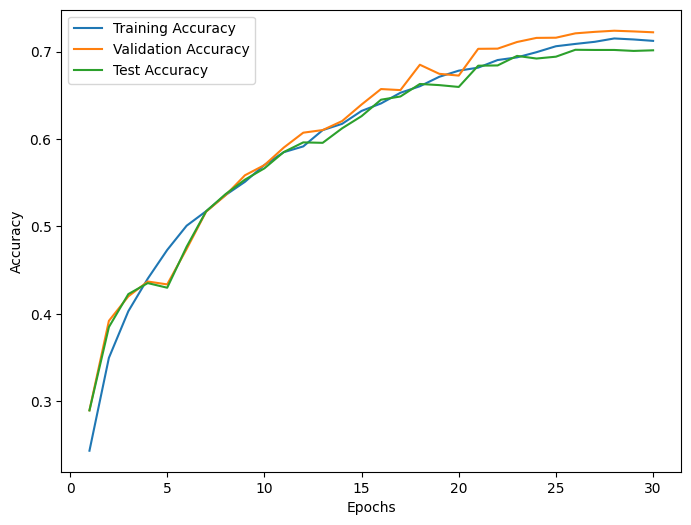

In [ ]:
plt.figure(figsize=(8, 6))

epochs = len(train_accuracies)  # or len(val_acc), whichever is correct
x_values = list(range(1, epochs + 1))

plt.plot(x_values, train_accuracies, label='Training Accuracy')
plt.plot(x_values, val_accuracies, label='Validation Accuracy')
plt.plot(x_values, test_accuracies, label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [ ]:

def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()


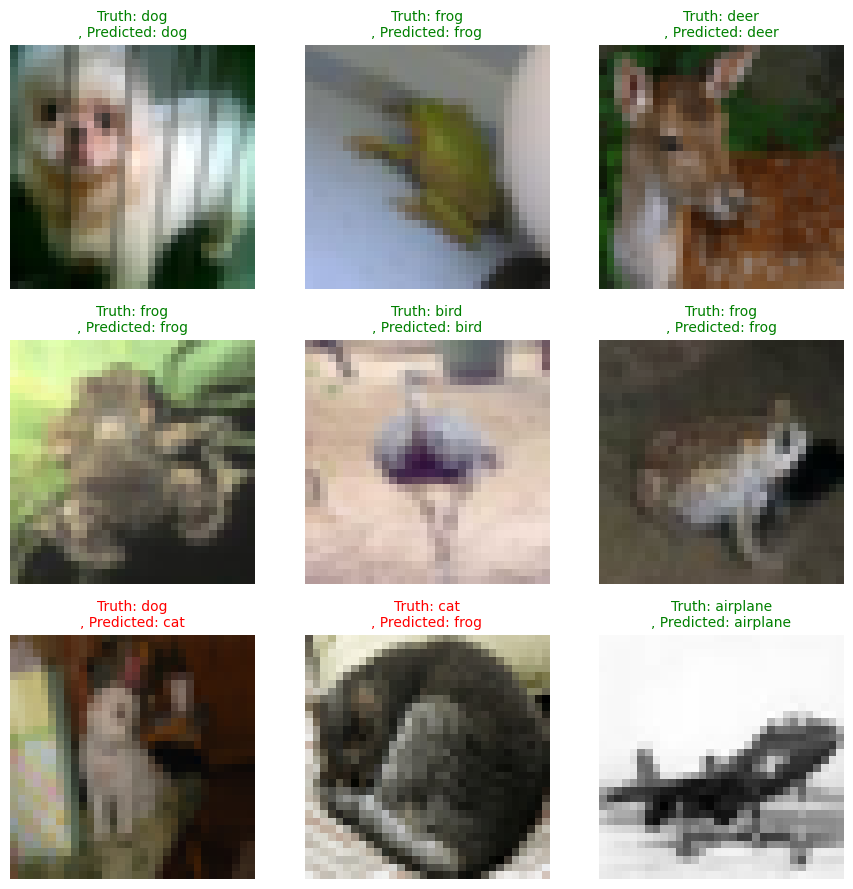

In [ ]:
predict_and_plot_grid(model,test_dataset,classes=train_subset.dataset.classes,grid_size=3)

In [ ]:
# Save the entire model
torch.save(model, 'best_vit_model.pth')
torch.save(model.state_dict(), 'best_vit_cifar10_weights.pth')
from google.colab import files
#files.download('best_vit_cifar10_weights.pth')
files.download('best_vit_model.pth')
# Load it back
#model = torch.load('best_vit_model.pth')
#model.eval()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>